In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
%matplotlib inline
import seaborn as sns

import sys,os,pdb,copy,pickle
from importlib import reload
import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp
import database
db = database.db

import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)


67 sessions!
67 sessions!


<module 'switch_analysis_one_session' from '/mnt/home/szheng/projects/nmf_analysis/scripts/switch_analysis_one_session.py'>

In [2]:
# data_dir_full = '/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/'
data_dir_full = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)['data_dir_full'][0] #0
print(data_dir_full)
# load data
mat_to_return=prep.load_stuff(data_dir_full,sessionPulses='*SessionPulses.Events.mat')
# sessionPulses=mat_to_return['sessionPulses']
# filtered = mat_to_return['filtered']
behavior=mat_to_return['behavior']
# ripples = mat_to_return['ripples']
cell_metrics = mat_to_return['cell_metrics']

prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=False,extra_load={})
spk_beh_df=prep_res['spk_beh_df']
_,spk_beh_df = dpp.group_into_trialtype(spk_beh_df)
spk_beh_df,_=dpp.add_lin_binned(spk_beh_df,nbins=100)
cell_cols_d = prep_res['cell_cols_d']
beh_df = prep_res['beh_df']
beh_df_d,beh_df=dpp.group_into_trialtype(beh_df)
spike_trains = prep_res['spike_trains']


/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913


/mnt/home/szheng/ceph/envs/ssm/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


load *SessionPulses.Events.mat failed


In [3]:
reload(pa)
cell_cols = cell_cols_d['pyr']
fr_map_d,_,_ = pf.ratemap_from_spk_beh_df_alltrialtype(spk_beh_df,cell_cols_d['pyr'],speed_thresh=1,nbins=100,smth_in_bin=5,speed_key='v')
fr_map_dict=pa.get_fr_map_trial(spk_beh_df,cell_cols,trialtype_key='trial_type',speed_thresh=1.,order=['smooth','divide'],speed_key='v')
fr_map_trial_d = {k:val[0] for k,val in fr_map_dict.items()}
fr_map_trial_df_d=pd.concat({k:pf.fr_map_trial_to_df(fr_map_trial_d[k],cell_cols) for k in fr_map_dict.keys()},axis=0)


cant format into a dataframe
cant format into a dataframe


In [4]:
pf_res =pf.field_detection_both_avg_trial_wrapper(data_dir_full, dosave=True,force_reload=False,nbins = 100, 
                                        save_fn = 'place_field_avg_and_trial_vthresh.p', 
                                        shuffle_fn='fr_map_null_trialtype_vthresh.p',
                                        smth_in_bin=2.5, speed_thresh=1.,speed_key='v',load_only=True
                                        )

switch_res = saos.switch_analysis_one_session(data_dir_full,place_field_res=None,force_reload=False,nrepeats=1000,
                                              save_fn=saos.SAVE_FN(saos.FR_KEY),load_only=True)

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---


In [5]:
task_ind,tt_ind = 0,0
pf_param = pf_res['avg']['params'][task_ind,tt_ind]
changes_df = switch_res['avg']['changes_df'].loc[task_ind,tt_ind,0.3,'switch_magnitude',0.4].dropna(axis=1)
fr_map_trial_df = fr_map_trial_df_d.loc[task_ind,tt_ind].dropna(axis=1)

no_sw_fields = changes_df.loc[(changes_df.abs().sum(axis=1) ==0)].index
with_sw_fields = changes_df.loc[(changes_df.abs().sum(axis=1) !=0)].index

/tmp/ipykernel_429950/3810986821.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  changes_df = switch_res['avg']['changes_df'].loc[task_ind,tt_ind,0.3,'switch_magnitude',0.4].dropna(axis=1)


In [34]:
def preprocess(mat,preprocess=['zscore_neuron']):
    '''
    mat: Time x Neuron
    '''
    mat_p = copy.copy(mat)
    for pp in preprocess:
        if pp=='zscore_neuron':
            mat_p = scipy.stats.zscore(mat_p,axis=1,nan_policy='omit')
            mat_p = mat_p.dropna(axis=0)
        elif pp=='zscore_time':
            mat_p = scipy.stats.zscore(mat_p,axis=0,nan_policy='omit')
            mat_p = mat_p.dropna(axis=1)
            
    
    return mat_p
    

In [7]:
def plot_pca3d(toplot,color=None,fig=None,ax=None):
    if ax is None:
        fig=plt.figure(figsize=(8,8))
        ax = plt.axes(projection='3d')
    if color is None:
        color='C0'
    ax.scatter3D(toplot[:,0],toplot[:,1],toplot[:,2],c=color)
    ax.set_xlabel('pc1')
    ax.set_ylabel('pc2')
    ax.set_zlabel('pc3')
    return fig,ax
    

In [8]:
import sklearn
from sklearn.decomposition import PCA

# PCA

In [84]:
from scipy.ndimage import gaussian_filter1d
import sklearn
from sklearn.decomposition import PCA,SparsePCA,MiniBatchSparsePCA

import animate_helper as ah
reload(ah)

<module 'animate_helper' from '/mnt/home/szheng/projects/util_code/animate_helper.py'>

In [10]:
%matplotlib inline

In [11]:
import matplotlib.patches as mpatches
section_dict={'home':[0,15],'central':[15,74],'T':[74,111],'return side':[111,185],'return central':[185,222]}
def color_arms(lin,section_dict=None,color_l = None):
    if section_dict is None:
        section_dict={'home':[0,15],'central':[15,74],'T':[74,111],'return side':[111,185],'return central':[185,222]}
    if color_l is None:
        nsections = len(section_dict)
        color_l = ['C'+str(i) for i in range(nsections)]
    color_in_time = np.zeros_like(lin,dtype=object)
    legend_l = []
    for ii,(k,sec) in enumerate(section_dict.items()):
        if ii==0:
            mask = (lin >=sec[0]) & (lin<=sec[1])
        else:
            mask = (lin >sec[0]) & (lin<=sec[1])
        color_in_time[mask] = color_l[ii]
        legend =mpatches.Patch(color=color_l[ii], label=k)
        legend_l.append(legend)
        
    return color_in_time,legend_l,section_dict,color_l

from matplotlib.lines import Line2D
def marker_speed(speed,speed_range_dict=None,marker_l=None):
    
    if speed_range_dict is None:
        speed_range_dict = {'nan':np.nan,'stationary':[0,2],'low speed':[2,10],'high speed':[10,100]}
    if marker_l is None:
        marker_l_all = ['x','.','v','*','<','d','p','s'] # to be added or made more principled
        nsections = len(speed_range_dict)
        assert nsections <= len(marker_l_all)
        marker_l = marker_l_all[:nsections]
    marker_in_time = np.zeros_like(speed,dtype=object)
    legend_l = []
    for ii,(k,sec) in enumerate(speed_range_dict.items()):
        if isinstance(sec,list):
            if ii ==0:
                mask = (speed >=sec[0]) & (speed<=sec[1])
            else:
                mask = (speed >sec[0]) & (speed<=sec[1])
        else:
            mask = np.isnan(speed)
        marker_in_time[mask] = marker_l[ii]
#         legend =mpatches.Patch(marker=marker_l[ii], label=k)
#         legend =plt.scatter([],[],marker=marker_l[ii], label=k,color='k')
        legend=Line2D([0], [0], marker=marker_l[ii], color='k', label=k)
        legend_l.append(legend)
    return marker_in_time,legend_l,speed_range_dict,marker_l
        
    
    

In [12]:
import plot_ratemap_sequence as prs

In [139]:
reload(ph)

<module 'plot_helper' from '/mnt/home/szheng/projects/util_code/plot_helper.py'>

In [39]:
section_dict

{'home': [0, 15],
 'central': [15, 74],
 'T': [74, 111],
 'return side': [111, 185],
 'return central': [185, 222]}

In [25]:
data.shape

(10000, 422)

<AxesSubplot:xlabel='Time (s)'>

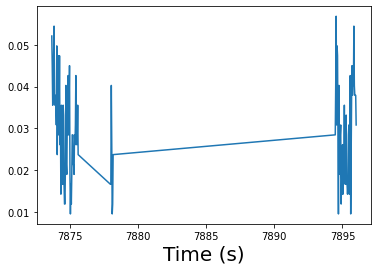

In [96]:
(X > 0).mean(axis=1).plot()

In [242]:
np.nonzero(np.isnan(X_smoothed))

(array([   0,    0,    0, ..., 1502, 1502, 1502]),
 array([117, 216, 249, ..., 401, 415, 418]))

<IPython.core.display.Javascript object>


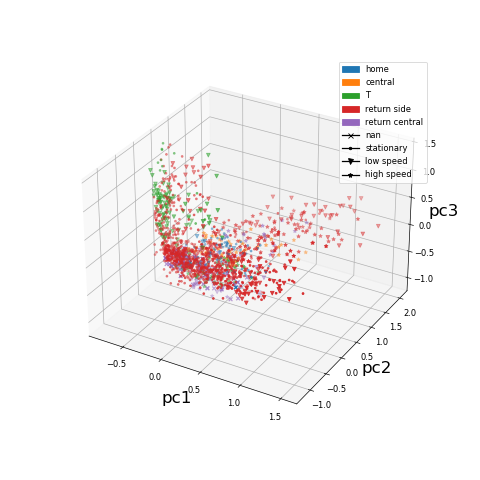

In [243]:
%matplotlib notebook
end = 10000
# spks_onetrial_ = spk_beh_df.query('trial==7').iloc[:end]

section_name = 'T'
section_bound = section_dict[section_name]
# spks_onetrial_ = spk_beh_df.query('lin>=@section_bound[0]&lin<=@section_bound[1]&trial<=1').iloc[:end]
spks_onetrial_ = spk_beh_df.query('trial==23').iloc[:end]
spks_onetrial = spks_onetrial_[cell_cols_d['pyr']]
lin = spks_onetrial_['lin'].values
color_in_time,legend_l_color,section_dict,color_l = color_arms(lin)

speed = spks_onetrial_['v'].abs().values
marker_in_time,legend_l_marker,speed_range_dict,marker_l = marker_speed(speed,speed_range_dict=None,marker_l=None)

legend_l = legend_l_color+legend_l_marker


# spks_onetrial = spks_onetrial.rolling(3).sum().iloc[::3].dropna(axis=0)
spks_onetrial_sqrt = np.sqrt(spks_onetrial.astype(float))

# data = spks_onetrial_sqrt.iloc[:,:50]
data = spks_onetrial_sqrt.iloc[:,:]

# mat_p = preprocess(data, preprocess=['zscore_time'])
mat_p = data

pca = PCA(n_components=20)
# pca = SparsePCA(n_components=3,alpha=0.1,ridge_alpha=0.01)
# pca = MiniBatchSparsePCA(n_components=3,alpha=0.1,ridge_alpha=0.01)
X = mat_p

X_smoothed = gaussian_filter1d(X,sigma=1,axis=0)

# center
X_smoothed = X_smoothed - X_smoothed.mean(axis=0,keepdims=True)
# normalize
# std = X_smoothed.std(axis=0,keepdims=True)
# X_smoothed = np.divide(X_smoothed, std , out=np.zeros_like(X_smoothed),where=std!=0)

max = X_smoothed.max(axis=0,keepdims=True)
X_smoothed = np.divide(X_smoothed, max , out=np.zeros_like(X_smoothed),where=max!=0)

X_reduced = pca.fit_transform(X_smoothed)
X_reduced_sub = X_reduced[:,:3]

pc_df = pd.DataFrame(pca.components_.T)
pc_df.index = X.columns

fig,ax=ph.plot_pca3d(X_reduced_sub,color=color_in_time,marker=marker_in_time)
ax.legend(handles=legend_l)

In [219]:
# %matplotlib notebook
# X_reduced_sub = X_reduced[:,[0,1,2]]
# fig,ax=ph.plot_pca3d(X_reduced_sub,color=color_in_time,marker=marker_in_time)
# ax.legend(handles=legend_l)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


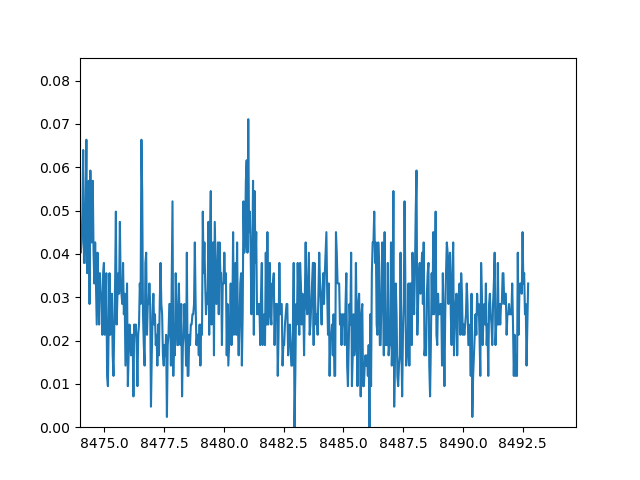

<IPython.core.display.Javascript object>


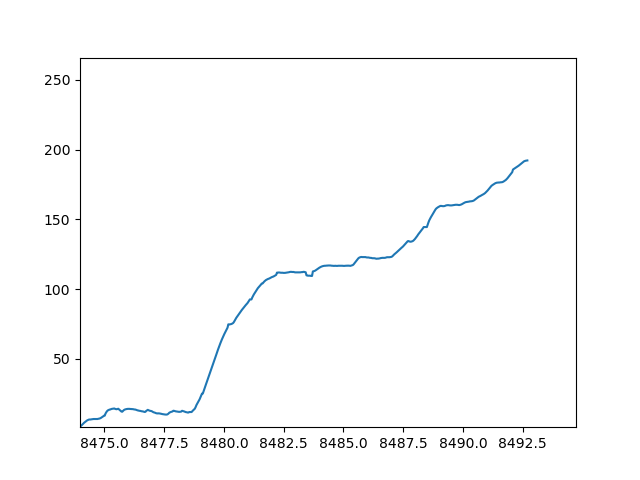

In [136]:
%matplotlib notebook
perc_firing_data = (X > 0).mean(axis=1).reset_index().values.T
fig,ax,ani_perc = ah.animate_line(perc_firing_data,legend_handles=None,color_l=None,fig=None,ax=None,ax_kws={},animate_kws=animate_kws,dosave=False)

pos_data = spks_onetrial_['lin'].reset_index().values.T
fig,ax,ani_line = ah.animate_line(pos_data,legend_handles=None,color_l=None,fig=None,ax=None,ax_kws={},animate_kws=animate_kws,dosave=False)


<IPython.core.display.Javascript object>


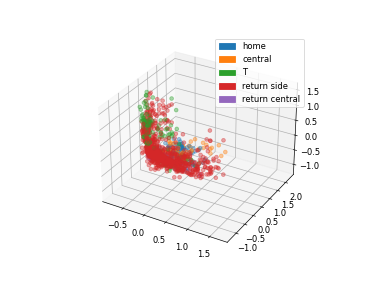

<IPython.core.display.Javascript object>


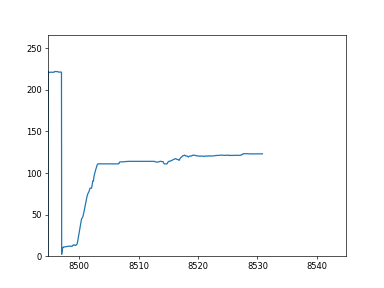

In [244]:
%matplotlib notebook
reload(ph)
reload(ah)
animate_kws = {'interval':10}
fig,ax,ani=ah.animate_3d_scatter(X_reduced_sub.T,color_l=color_in_time,legend_handles=legend_l_color,animate_kws=animate_kws)

pos_data = spks_onetrial_['lin'].reset_index().values.T
fig,ax,ani_line = ah.animate_line(pos_data,legend_handles=None,color_l=None,fig=None,ax=None,ax_kws={},animate_kws=animate_kws,dosave=False)




In [222]:
mask = (spks_onetrial_['lin'] >=section_dict['T'][0]) & (spks_onetrial_['lin'] <=section_dict['T'][1])
mask = mask.values

<IPython.core.display.Javascript object>


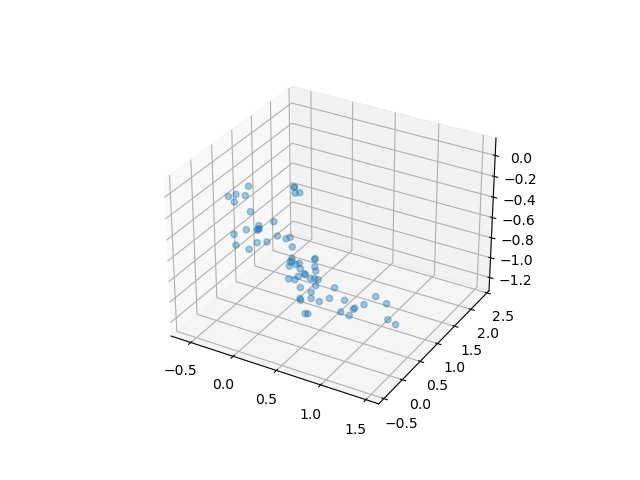

<IPython.core.display.Javascript object>


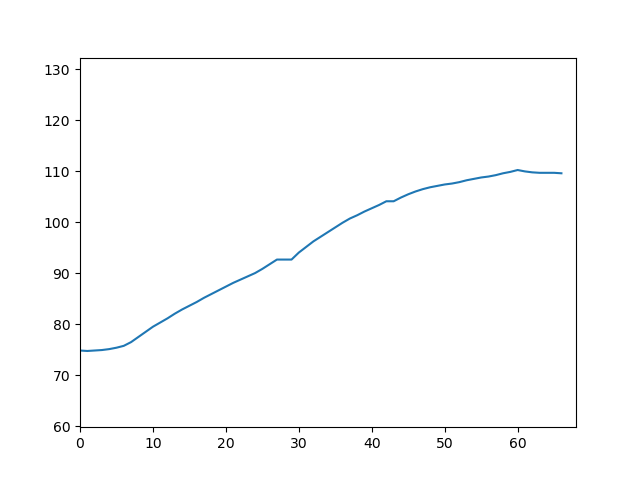

In [231]:
animate_kws = {'interval':20}
fig,ax,ani=ah.animate_3d_scatter(X_reduced_sub[mask].T,animate_kws=animate_kws)

pos_data_sub = copy.deepcopy(pos_data[:,mask])
pos_data_sub[0,:] = np.arange(pos_data_sub.shape[1])
fig,ax,ani_line = ah.animate_line(pos_data_sub,legend_handles=None,color_l=None,fig=None,ax=None,ax_kws={},animate_kws=animate_kws,dosave=False)

In [194]:
import matplotlib.animation as animation

In [226]:
writervideo = animation.ImageMagickWriter(fps=20)
ani.save('back_and_forth.gif', writer=writervideo)

<IPython.core.display.Javascript object>


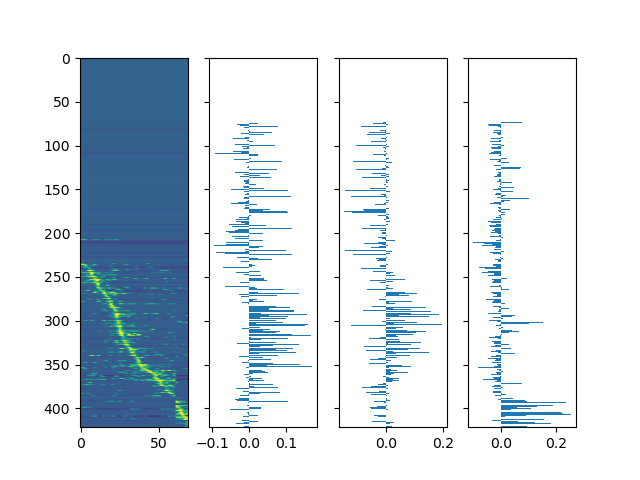

In [225]:
%matplotlib notebook
X_segment = pd.DataFrame(X_smoothed[mask].T,index=X.columns)
fig,axs=plt.subplots(1,4,sharey=True)
fig,ax,order=prs.plot_population_sequence(X_segment,normalize=False,fig=fig,ax=axs[0])
for i in range(0,3):
    axs[i+1].barh(np.arange(pc_df.shape[0]),pc_df[i].loc[order])

In [ ]:
pc_df

In [89]:
import nmf_analysis as na
W_inds,W_sorted,factor_assignment=na.sort_factors(pc_df.values)

In [90]:
pc_df_sorted = pc_df.iloc[W_inds.astype(int),:]

<AxesSubplot:>

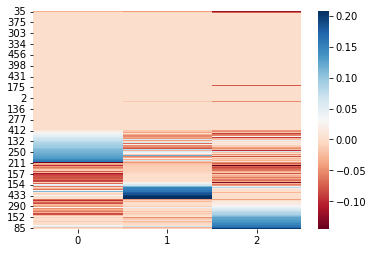

In [82]:
%matplotlib inline
sns.heatmap(pc_df_sorted,cmap='RdBu')

<AxesSubplot:xlabel='lin_binned'>

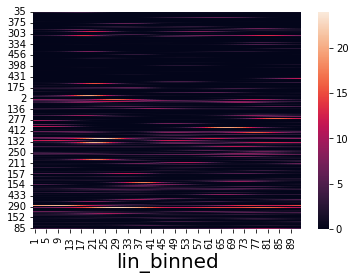

In [83]:
sns.heatmap(fr_map_d[task_ind,tt_ind].loc[pc_df_sorted.index])

<BarContainer object of 20 artists>

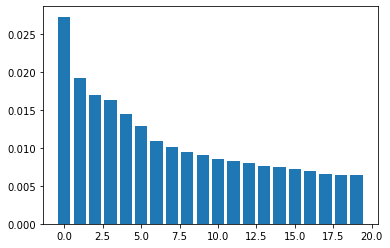

In [40]:
%matplotlib inline
evr=pca.explained_variance_ratio_
plt.bar(np.arange(len(evr)),evr)

In [71]:
section_bound

[111, 185]

In [85]:
task_ind,tt_ind = 0,0
tuning = fr_map_d[task_ind,tt_ind] / fr_map_d[task_ind,tt_ind].sum(axis=1)

In [86]:
tuning_within_sec = tuning.loc[:,(section_bound[0]/2.2):(section_bound[1]/2.2)].mean(axis=1)

In [87]:
pc_df['tuning_within_sec'] = tuning_within_sec

In [88]:
pc_df.corr()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,tuning_within_sec
0,1.000000,-0.071488,0.054766,-0.194698,-0.076459,-0.064422,0.002501,0.069663,-0.006408,-0.018747,...,0.004459,0.012544,0.006675,0.010688,-0.064363,-0.025320,-0.020664,-0.062661,0.025002,0.322058
1,-0.071488,1.000000,0.032915,-0.117018,-0.045954,-0.038719,0.001503,0.041869,-0.003851,-0.011267,...,0.002680,0.007539,0.004012,0.006424,-0.038684,-0.015218,-0.012420,-0.037661,0.015027,-0.453386
2,0.054766,0.032915,1.000000,0.089645,0.035204,0.029662,-0.001152,-0.032075,0.002950,0.008632,...,-0.002053,-0.005776,-0.003074,-0.004921,0.029635,0.011658,0.009514,0.028851,-0.011512,-0.061151
3,-0.194698,-0.117018,0.089645,1.000000,-0.125156,-0.105452,0.004094,0.114031,-0.010489,-0.030686,...,0.007299,0.020533,0.010927,0.017495,-0.105355,-0.041446,-0.033825,-0.102569,0.040925,-0.319347
4,-0.076459,-0.045954,0.035204,-0.125156,1.000000,-0.041412,0.001608,0.044781,-0.004119,-0.012051,...,0.002866,0.008063,0.004291,0.006870,-0.041374,-0.016276,-0.013283,-0.040280,0.016072,0.280467
5,-0.064422,-0.038719,0.029662,-0.105452,-0.041412,1.000000,0.001355,0.037731,-0.003471,-0.010153,...,0.002415,0.006794,0.003615,0.005789,-0.034860,-0.013714,-0.011192,-0.033938,0.013541,0.098150
6,0.002501,0.001503,-0.001152,0.004094,0.001608,0.001355,1.000000,-0.001465,0.000135,0.000394,...,-0.000094,-0.000264,-0.000140,-0.000225,0.001353,0.000532,0.000435,0.001318,-0.000526,-0.239939
7,0.069663,0.041869,-0.032075,0.114031,0.044781,0.037731,-0.001465,1.000000,0.003753,0.010980,...,-0.002612,-0.007347,-0.003910,-0.006260,0.037696,0.014829,0.012103,0.036699,-0.014643,-0.044904
8,-0.006408,-0.003851,0.002950,-0.010489,-0.004119,-0.003471,0.000135,0.003753,1.000000,-0.001010,...,0.000240,0.000676,0.000360,0.000576,-0.003467,-0.001364,-0.001113,-0.003376,0.001347,-0.100719
9,-0.018747,-0.011267,0.008632,-0.030686,-0.012051,-0.010153,0.000394,0.010980,-0.001010,1.000000,...,0.000703,0.001977,0.001052,0.001684,-0.010144,-0.003991,-0.003257,-0.009876,0.003941,0.008076


<IPython.core.display.Javascript object>


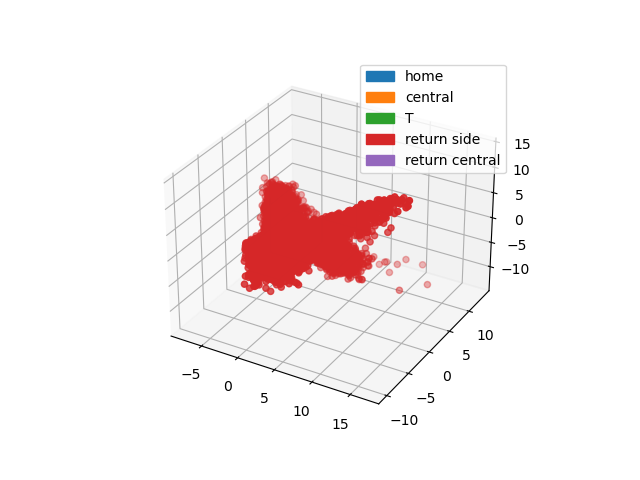

<IPython.core.display.Javascript object>


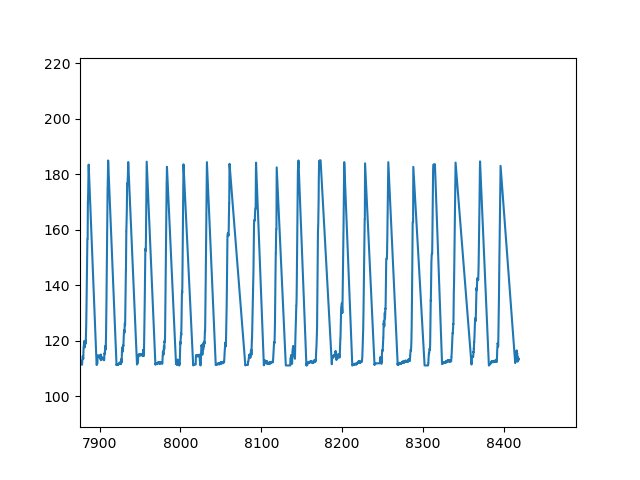

In [92]:
reload(ph)
animate_kws = {'interval':1}
fig,ax,ani=ah.animate_3d_scatter(X_reduced.T,color_l=color_in_time,legend_handles=legend_l_color,animate_kws=animate_kws)

pos_data = spks_onetrial_['lin'].reset_index().values.T
fig,ax,ani_line = ah.animate_line(pos_data,legend_handles=None,color_l=None,fig=None,ax=None,ax_kws={},animate_kws=animate_kws,dosave=False)




<IPython.core.display.Javascript object>


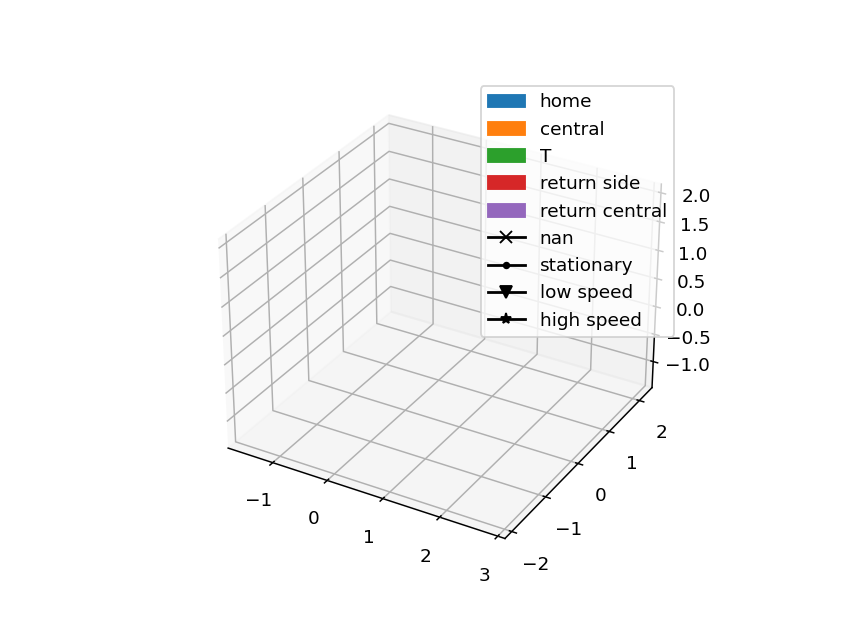

(<Figure size 640x480 with 1 Axes>,
 <Axes3DSubplot:>,
 <matplotlib.animation.FuncAnimation at 0x1554cc9af9d0>)

In [30]:
# ph.animate_3d_scatter(X_reduced.T,legend_handles=legend_l,color_l=color_in_time,marker_l=marker_in_time)

<AxesSubplot:xlabel='Time (s)'>

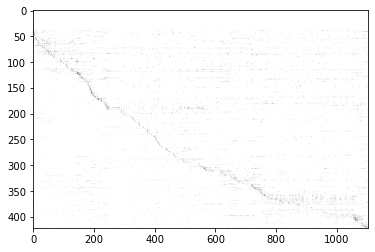

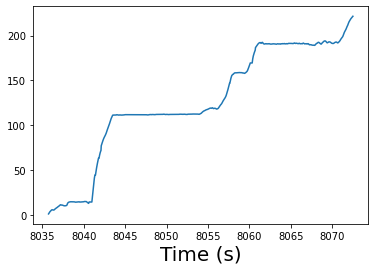

In [27]:
%matplotlib inline
fig,ax,order=prs.plot_population_sequence(spks_onetrial.T)
plt.figure()
spks_onetrial_['lin'].plot()

<IPython.core.display.Javascript object>


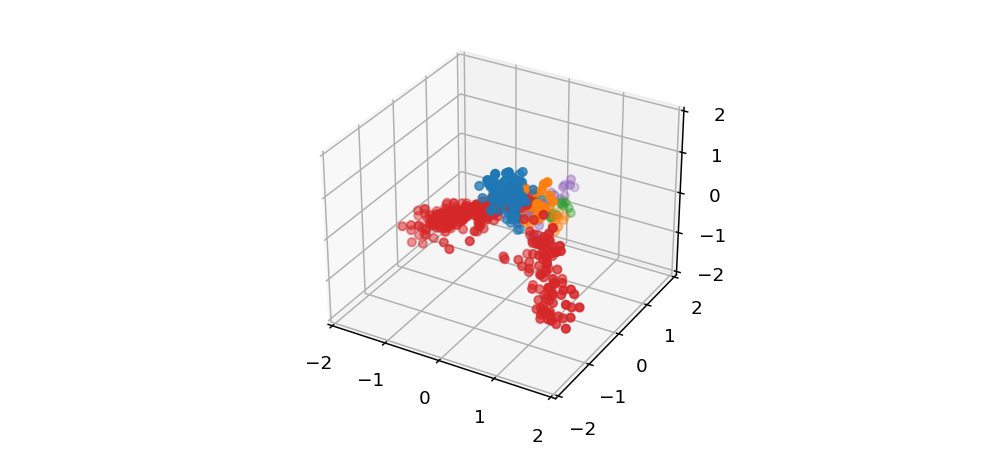

In [104]:
from matplotlib.animation import FuncAnimation,ArtistAnimation
fig = plt.figure()
ax3d = fig.add_subplot(projection='3d')
# ax = fig.add_subplot()
xdata,ydata,zdata=[],[],[]
# ln,=ax3d.plot([],[],[],'o')
# ln,=ax.plot([],[],'o')

def init():
    ax3d.set(xlim=[-2,2],ylim=[-2,2],zlim=[-2,2])
    return ln,
xdata_l,ydata_l,zdata_l = X_reduced[:,0],X_reduced[:,1],X_reduced[:,2]


# ln,=ax3d.plot(xdata_l[0],ydata_l[0],zdata_l[0],marker='o',markersize=1)
scat=ax3d.scatter(xdata_l[0],ydata_l[0],zdata_l[0])

def animate(frame,data,scat,color_l):
    xdata.append(xdata_l[frame])
    ydata.append(ydata_l[frame])
    zdata.append(zdata_l[frame])
#     ln.set_data(xdata,ydata,zdata)
#     ln.set_data(data[0:2,:frame],c=color_l[frame])

#     ln.set_3d_properties(data[2,:frame])
    scat._offsets3d = data[:,:frame]
    scat.set_color(color_l[:frame])
#     ln.set_data(xdata,ydata)
    return ln,

data = X_reduced.T
ani = FuncAnimation(fig,animate,init_func=init,fargs=(data,scat,color_in_time),blit=False,frames=data.shape[1])
plt.show()


# LDS

In [17]:
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.gridspec import GridSpec

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

color_names = ["windows blue",
               "red",
               "amber",
               "faded green",
               "dusty purple",
               "orange",
               "clay",
               "pink",
               "greyish",
               "mint",
               "light cyan",
               "steel blue",
               "forest green",
               "pastel purple",
               "salmon",
               "dark brown"]

colors = sns.xkcd_palette(color_names)

import ssm
from ssm.util import random_rotation
from ssm.plots import plot_dynamics_2d

# Specify whether or not to save figures
save_figures = False


In [18]:
cell_cols_d['pyr']

array([  1.,  39.,  40.,  42.,  46.,  47.,  48.,  49.,  50.,  52.,  53.,
        54.,  55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,
        65.,  66.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
       100., 101., 102., 103., 104., 105., 106., 107., 108., 109., 110.,
       111., 112., 113., 114., 115., 116., 117., 118., 119., 120., 121.,
       122., 123., 124., 125., 126., 127., 128., 129., 130., 131., 132.,
       133., 134., 135., 136., 137., 138., 139., 140., 141., 142., 143.,
       144., 145., 146., 147., 148., 149., 150., 151., 152., 153., 154.,
       155., 156., 157., 158., 160., 161., 162., 163., 164., 165., 166.,
       167., 168., 169., 170., 171., 172., 173., 174., 175., 176., 177.,
       178., 179., 180., 181., 182., 183., 184., 185., 186., 187., 188.,
       189., 190., 191., 192., 193., 194., 195., 19

In [19]:
spks_onetrial = spk_beh_df.query('trial==1')[cell_cols_d['pyr']]
spks_onetrial = spks_onetrial.rolling(3).sum().iloc[::3].dropna(axis=0)
spks_onetrial_sqrt = np.sqrt(spks_onetrial.astype(float))

data = spks_onetrial_sqrt.values[:,:50]

In [78]:


# Set the parameters of the LDS
time_bins = data.shape[0]   # number of time bins
state_dim = 4     # number of latent dimensions
obs_dim = data.shape[1]      # number of observed dimensions




In [79]:
lds = ssm.LDS(obs_dim, state_dim, emissions="gaussian_orthog")
elbos, q = lds.fit(data, method="laplace_em", num_iters=10)

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

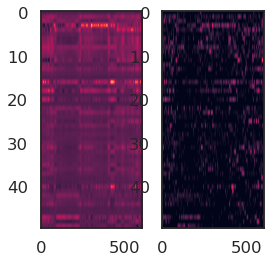

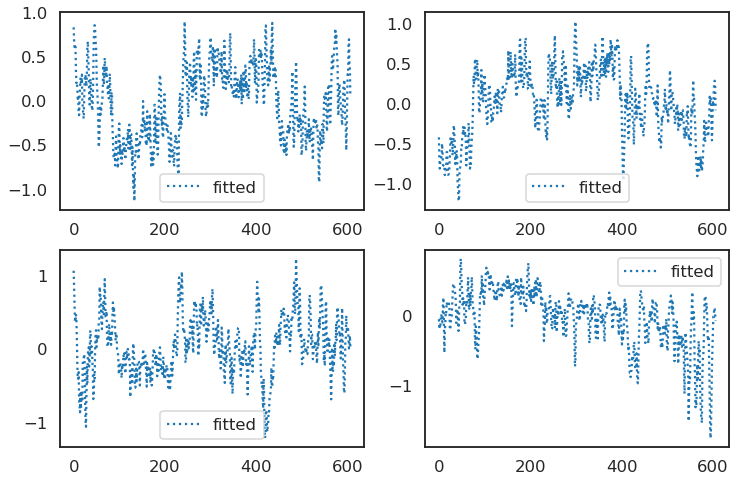

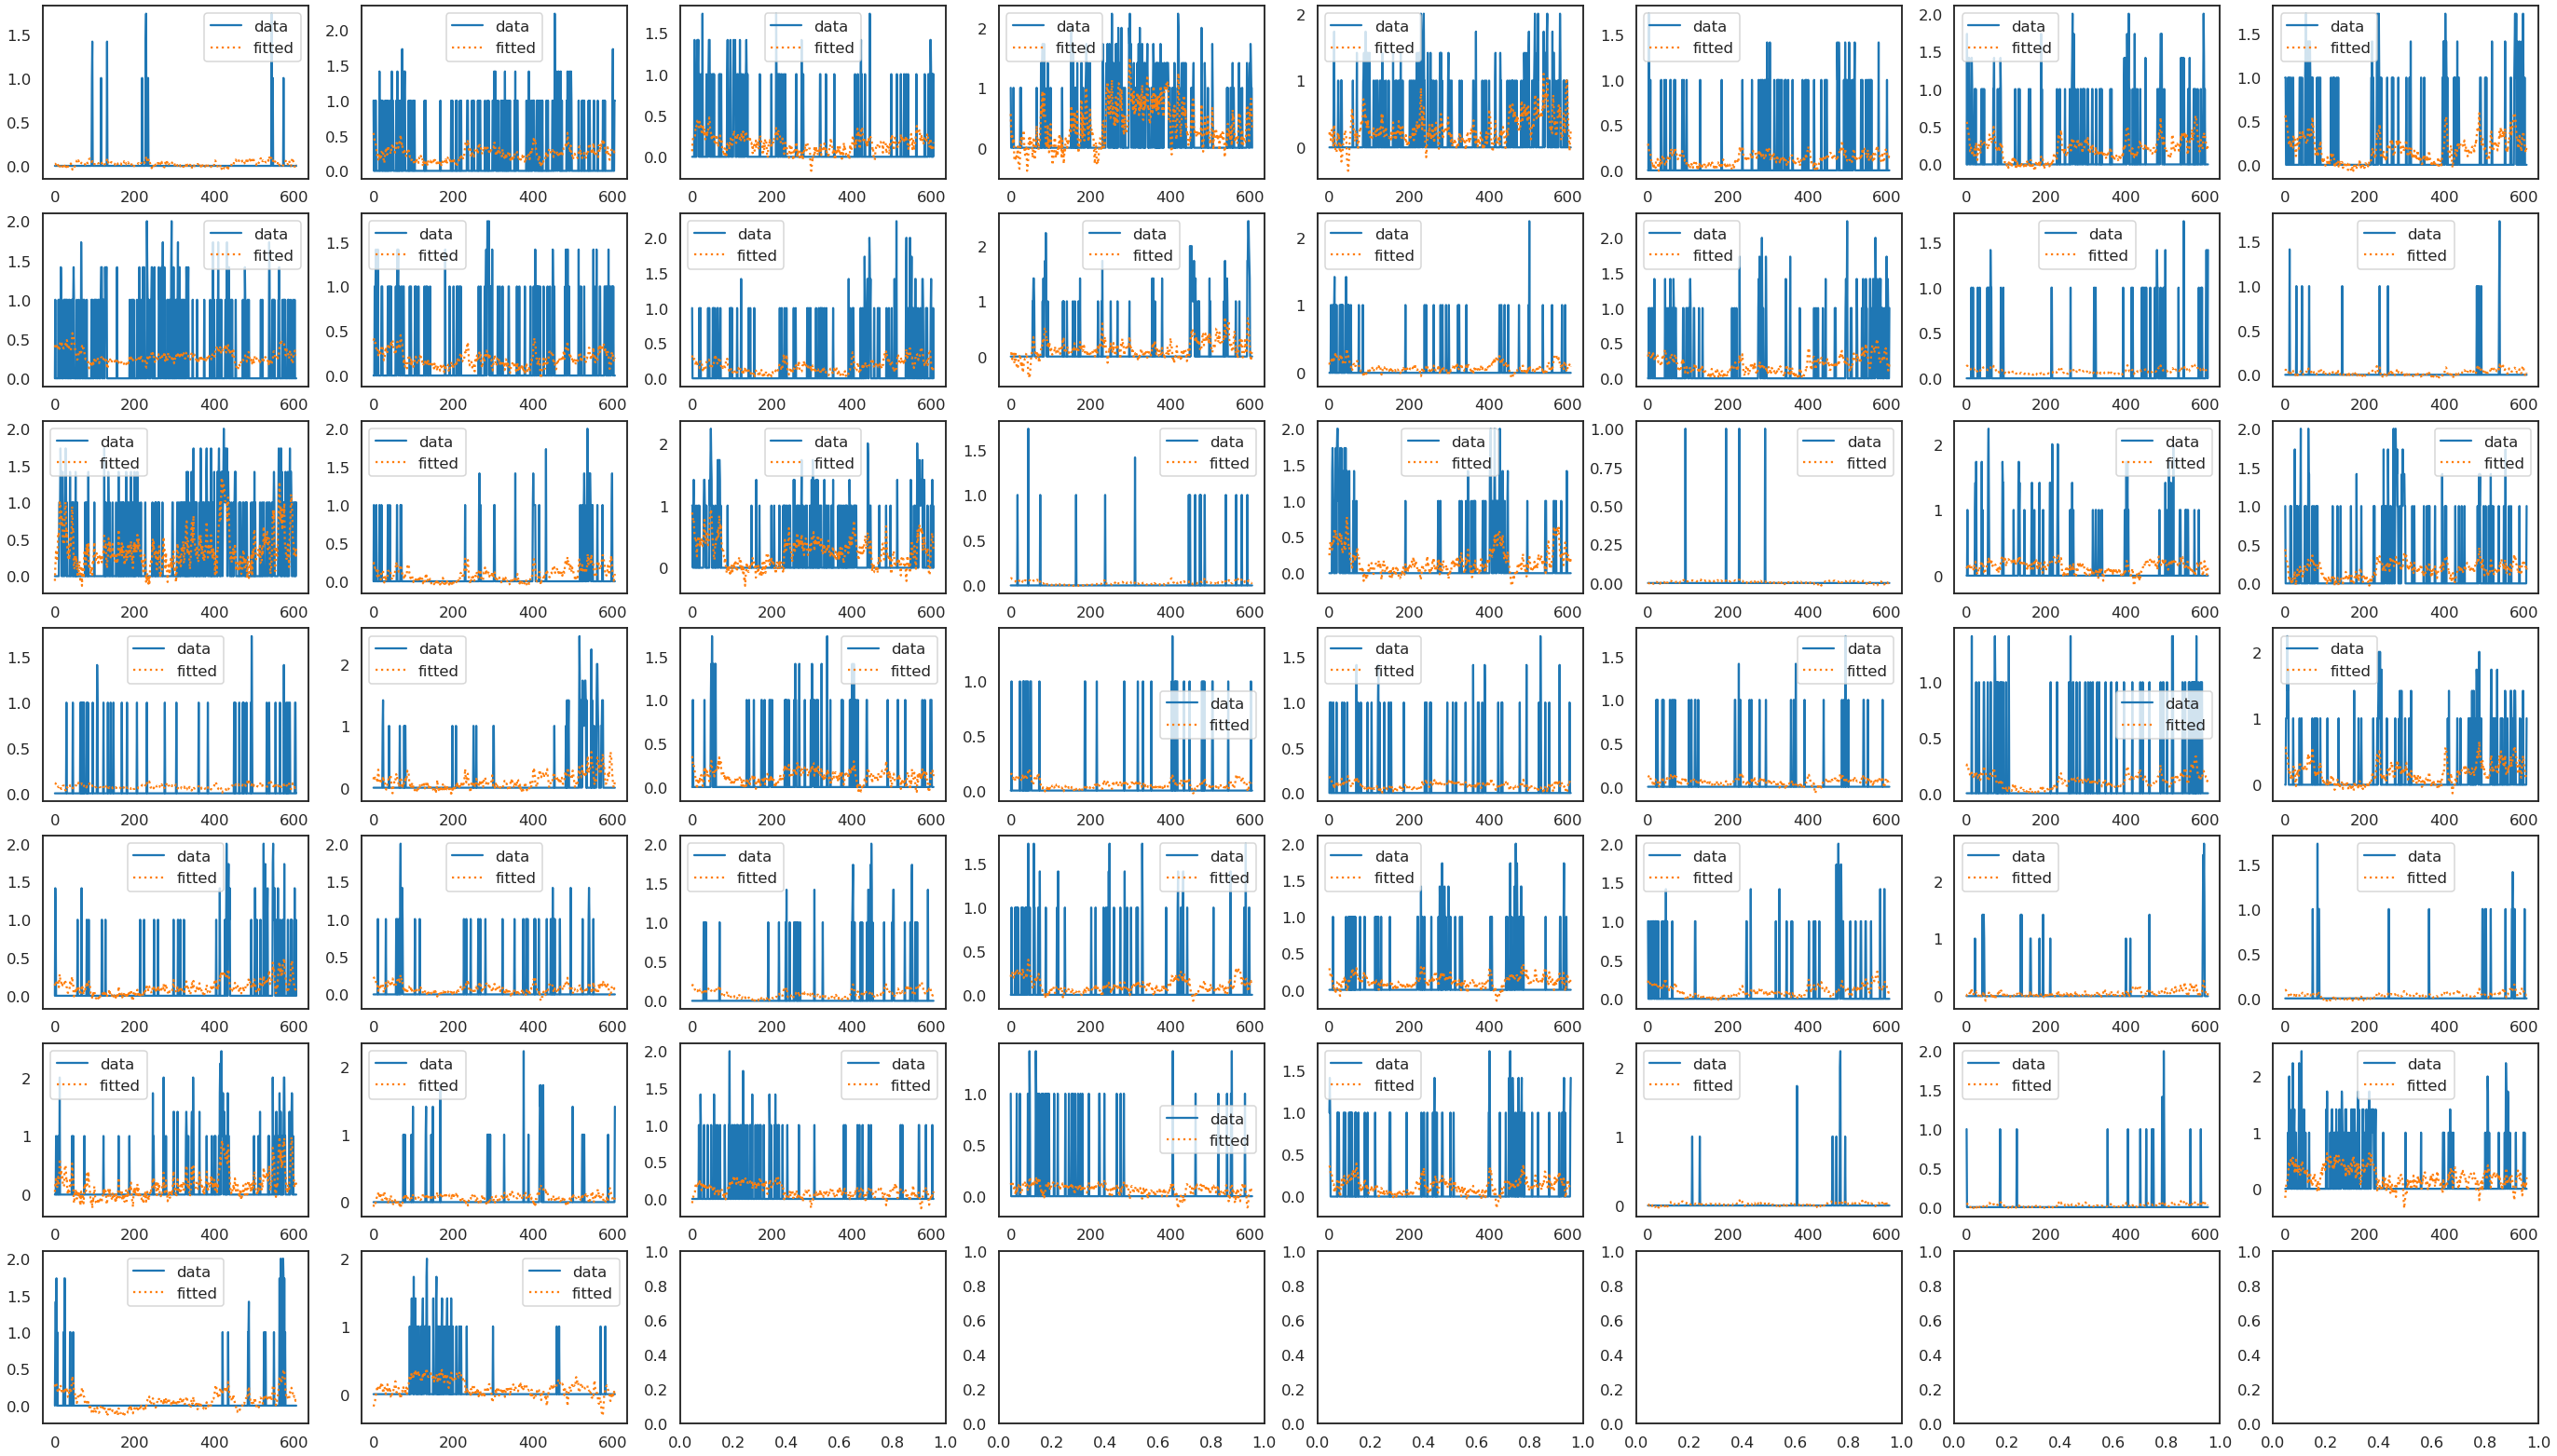

In [80]:
state_means = q.mean_continuous_states[0]

smoothed_obs = lds.smooth(state_means, data)

fig,axs=plt.subplots(1,2,figsize=(4,4))
axs[0].imshow(smoothed_obs.T,aspect='auto')
axs[1].imshow(data.T,aspect='auto')

# plot states
nplots = state_means.shape[1]
fig,axs=ph.subplots_wrapper(nplots)
for ii in range(nplots):
    ax=axs.ravel()[ii]
#     ax.plot(data[:,ii],linestyle='-',label='data')
    ax.plot(state_means[:,ii],linestyle=':',label='fitted')
    ax.legend()

# plot obs
nplots = data.shape[1]
fig,axs=ph.subplots_wrapper(nplots)
for ii in range(nplots):
    ax=axs.ravel()[ii]
    ax.plot(data[:,ii],linestyle='-',label='data')
    ax.plot(smoothed_obs[:,ii],linestyle=':',label='fitted')
    ax.legend()

# corr = np.corrcoef(data.T)
# np.set_printoptions(precision=3,suppress=True)
# plt.figure()
# plt.imshow(corr)

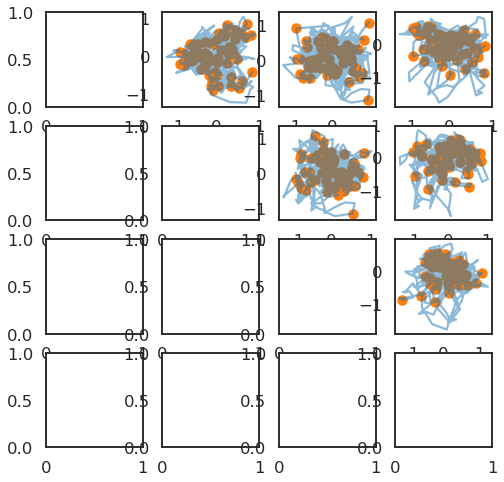

In [81]:
nstates = state_means.shape[1]
fig,axs=plt.subplots(nstates,nstates,figsize=(nstates*2,nstates*2))
for i in range(nstates):
    for j in range(i+1,nstates):
        ax=axs[i,j]
        ax.plot(state_means[:,i],state_means[:,j],alpha=0.5)
        ax.scatter(state_means[::10,i],state_means[::10,j],color='C1')

In [82]:
import sklearn
from sklearn.decomposition import PCA

In [ ]:
data = (data - np.mean(data,axis=0,keepdims=True))/np.std(data,axis=0,keepdims=True)

In [99]:
pca=PCA(n_components=3)
data_pca_trans = pca.fit_transform(data)

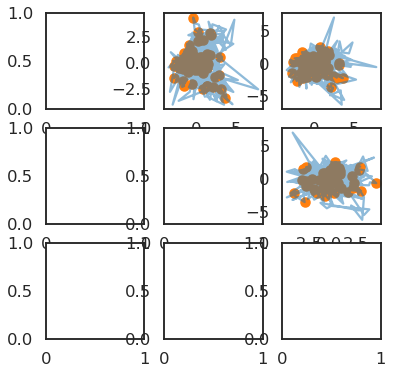

In [100]:
state_means = data_pca_trans
nstates = state_means.shape[1]
fig,axs=plt.subplots(nstates,nstates,figsize=(nstates*2,nstates*2))
for i in range(nstates):
    for j in range(i+1,nstates):
        ax=axs[i,j]
        ax.plot(state_means[:,i],state_means[:,j],alpha=0.5)
        ax.scatter(state_means[::10,i],state_means[::10,j],color='C1')

In [90]:


from mpl_toolkits import mplot3d



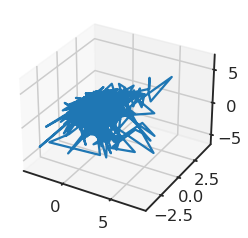

In [101]:
fig = plt.figure()
ax=fig.add_subplot(projection='3d')
ax.plot(data_pca_trans[:,0],data_pca_trans[:,1],data_pca_trans[:,2])

In [ ]:
fig,ax=plt.subplots()
plot_dynamics_2d(A_true, b_true, npts=10, axis=ax)

In [ ]:
# Make an LDS with somewhat interesting dynamics parameters
lds = ssm.LDS(obs_dim, state_dim, emissions="gaussian_orthog")
elbos, q = lds.fit(data, method="laplace_em", num_iters=10)

In [ ]:


data = obs_plds#emissions

print("Fitting LDS with Laplace-EM using structured variational posterior")
# lds = ssm.LDS(obs_dim, state_dim, emissions="gaussian")
lds = ssm.LDS(obs_dim, state_dim, emissions="poisson_orthog",emission_kwargs=dict(link="softplus"))
elbos, q = lds.fit(data, method="laplace_em", num_iters=10)

# Get the posterior mean of the continuous states
state_means = q.mean_continuous_states[0]

# Smooth the data under the variational posterior
smoothed_obs = lds.smooth(state_means, data)



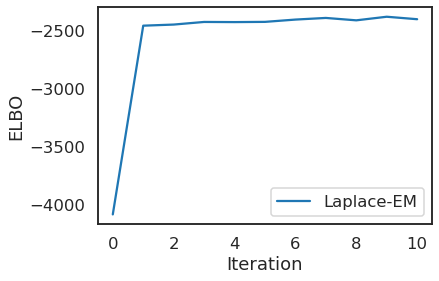

In [35]:


# Plot the ELBOs
plt.plot(elbos, label="Laplace-EM")
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.legend()



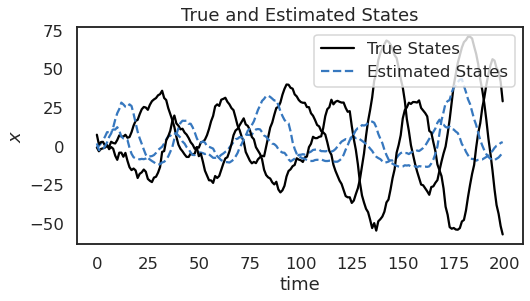

In [33]:


plt.figure(figsize=(8,4))
for d in range(state_dim):
    plt.plot(states[:,d] + 4 * d, '-k', label="True States" if d==0 else None)
    plt.plot(state_means[:,d] + 4 * d, '--', color=colors[0], label="Estimated States" if d==0 else None)
plt.ylabel("$x$")
plt.xlabel("time")
plt.legend(loc='upper right')
plt.title("True and Estimated States")
plt.show()



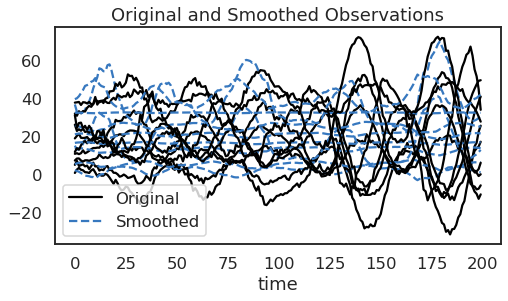

In [26]:


# Plot the smoothed emissions
plt.figure(figsize=(8,4))
for n in range(obs_dim):
    plt.plot(emissions[:, n] + 4 * n, '-k', label="Original" if n == 0 else None)
    plt.plot(smoothed_obs[:, n] + 4 * n, '--', color=colors[0], label="Smoothed" if n == 0 else None)
plt.legend()
plt.xlabel("time")
plt.title("Original and Smoothed Observations")
plt.show()



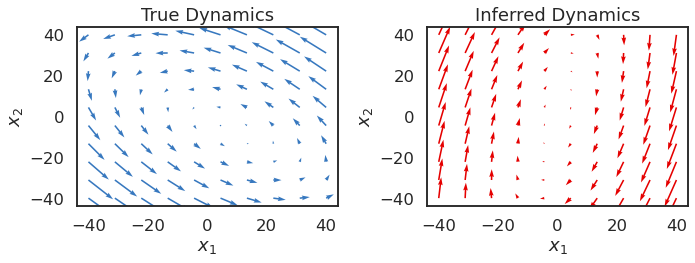

In [27]:


# Extract dynamics matrix from the true model
A_true = true_lds.dynamics.A
b_true = true_lds.dynamics.b

A_est = lds.dynamics.A
b_est = lds.dynamics.b

f, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_dynamics_2d(A_true, b_true, npts=10, axis=ax[0], color=colors[0])
ax[0].set_xlabel("$x_1$")
ax[0].set_ylabel("$x_2$")
ax[0].set_title("True Dynamics")

plot_dynamics_2d(A_est, b_est, npts=10, axis=ax[1], color=colors[1])
ax[1].set_xlabel("$x_1$")
ax[1].set_ylabel("$x_2$")
ax[1].set_title("Inferred Dynamics")

plt.tight_layout()



In [20]:


import copy

plds = ssm.LDS(obs_dim, state_dim, emissions="poisson_orthog", emission_kwargs=dict(link="softplus"))
plds.dynamics.params = copy.deepcopy(true_lds.dynamics.params)
plds.emissions.ds = 0 * np.ones(obs_dim)
states_plds, obs_plds = plds.sample(time_bins)



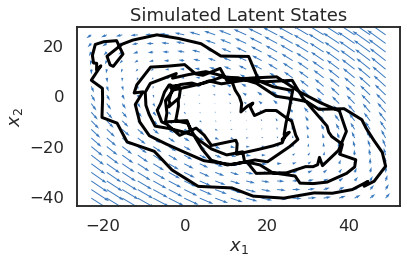

In [21]:
# Plot the dynamics vector field
plot_dynamics_2d(plds.dynamics.A,
                 plds.dynamics.b,
                 mins=states_plds.min(axis=0),
                 maxs=states_plds.max(axis=0),
                 color=colors[0])
plt.plot(states_plds[:,0], states_plds[:,1], '-k', lw=3)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Simulated Latent States")
plt.tight_layout()

if save_figures:
    plt.savefig("lds_6.pdf")

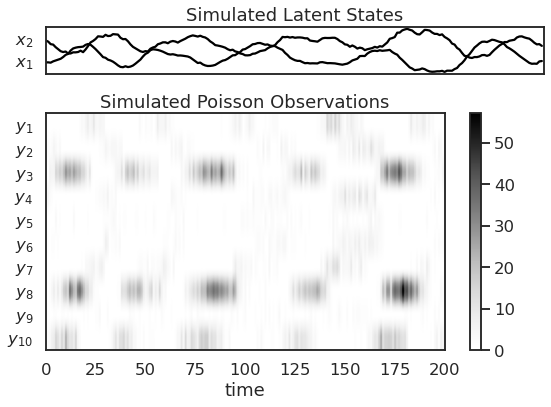

In [22]:
# Plot the dynamics vector field
plt.figure(figsize=(8, 6))
gs = GridSpec(2, 1, height_ratios=(1, obs_dim/state_dim))

# Plot the continuous latent states
lim = abs(states_plds).max()
plt.subplot(gs[0])
for d in range(state_dim):
    plt.plot(states_plds[:, d] + lim * d, '-k')
plt.yticks(np.arange(state_dim) * lim, ["$x_{}$".format(d+1) for d in range(state_dim)])
plt.xticks([])
plt.xlim(0, time_bins)
plt.title("Simulated Latent States")

lim = abs(obs_plds).max()
plt.subplot(gs[1])
plt.imshow(obs_plds.T, cmap="Greys", aspect="auto")
plt.yticks(np.arange(obs_dim), ["$y_{{ {} }}$".format(n+1) for n in range(obs_dim)])
plt.xlabel("time")
plt.xlim(0, time_bins)
plt.title("Simulated Poisson Observations")
plt.colorbar()

plt.tight_layout()

if save_figures:
    plt.savefig("lds_7.pdf")